In [1]:
import os
import numpy as np
import pandas as pd
import scipy
from scipy.sparse import issparse, csr
import scanpy as sc

import torch
from torch.utils.data import Dataset
from torch.utils.data.sampler import Sampler
from torch.utils.data import DataLoader

from anndata import AnnData
import anndata as ad
import scanpy as sc
from sklearn.preprocessing import maxabs_scale, MaxAbsScaler

import math
from glob import glob

import warnings

# 忽略警告
warnings.filterwarnings("ignore", category=UserWarning)

In [2]:
import random
seed = 666
np.random.seed(seed)
random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

### Integrate all batches

In [3]:
## 读取数据
adata = sc.read_h5ad('./SymSim_Data/adata_simulation.h5ad')  #Load cell line dataset(-> count data). 
# celltype = adata.obs['celltype']

In [4]:
adata.obs['Batch0'].unique()

['batch-1', 'batch-2', 'batch-3']
Categories (3, object): ['batch-1', 'batch-2', 'batch-3']

In [5]:
adata.obs['Batch0'].value_counts()

Batch0
batch-1    309
batch-2    292
batch-3    219
Name: count, dtype: int64

In [6]:
from ccvae.step1_partition import run_partition
import time
start_time = time.time()
batch_key = 'Batch0'  # 批次信息保存在 adata.obs['batch'] 列中
num_iterations = 1 # number of re-sampling 
ccPairs_adata, rest_adata = run_partition(adata, batch_key, num_iterations,
                                          sample_ratio=1, drop_last=True, omics='scRNA',
                                          nHVGs=1000, npcs=20, singular_ratio=0.9, canonical_ratio=0.9, 
                                          metric='euclidean', k1=20, k2=10, 
                                          normalization=True, min_genes=200, min_cells=3,
                                          Matchability=False, seed = seed, verbose=False)
print("Running time is ", (time.time()-start_time)/60)

/home/zhouwg/data/software/anaconda3/envs/PyTorch_study/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Preparing to calculating Anchor and Query Pairs...
Iteration 1/1
Data preprocess of reference...
Data preprocess of query...
PreProcess Done.
Iteration 1/1
Data preprocess of reference...
Data preprocess of query...
PreProcess Done.
Iteration 1/1
Data preprocess of reference...
Data preprocess of query...
PreProcess Done.
Finishing calculating cell-cell Pairs...
Running time is  0.4410521666208903


### Run  ccVAE

In [7]:
sc.settings.set_figure_params(dpi=200, frameon=False)
sc.set_figure_params(dpi=200)
sc.set_figure_params(figsize=(4, 4))
torch.set_printoptions(precision=3, sci_mode=False, edgeitems=7)

In [8]:
condition_key = 'Batch0'
cell_type_key = 'Group'

ccvae_epochs = 500
surgery_epochs = 500

early_stopping_kwargs = {
    "early_stopping_metric": "val_unweighted_loss",
    "threshold": 0,
    "patience": 20,
    "reduce_lr": True,
    "lr_patience": 13,
    "lr_factor": 0.1,
}

### Preparing data for ccVAE model

In [9]:
from ccvae.step2_ccVAE_utils import prepare_adata
source_adata,target_adata, source_conditions = prepare_adata(ccPairs_adata, rest_adata, n_top_genes=2000, condition_key=condition_key,
                                                             filter_min_counts=True, scale_factor=True, use_scale=False, 
                                                             use_logtrans=True, counts_per_cell=True, select_gene_adclust=True,
                                                             select_gene_desc=False, use_count=False)

In [10]:
print(condition_key)
print(source_conditions)

Batch0
['batch-1', 'batch-2', 'batch-3']


### MSE loss

In [15]:
from ccvae.step2_run_ccVAE import CCVAE

### Create TRVAE model and train it on reference dataset
ccvae = CCVAE(
    adata_ccPairs=source_adata,
    adata_rest=target_adata,
    #use_mmd = False,
    condition_key=condition_key,
    conditions=source_conditions,
    #cell_type_key=cell_type_key,
    hidden_layer_sizes=[128, 128],
    recon_loss=['mse','mse'],
    mmd_on = 'z',
)


INITIALIZING THE WHOLE CCVAE NETWORK..............

Initializing ccVAE SubNetwork(trVAE) for ccPairs cells:
Encoder Sub-Architecture of ccPairs cells:
	Input Layer in, out and cond: 1000 128 3
	Hidden Layer 1 in/out: 128 128
	Mean/Var Layer in/out: 128 10

Decoder Sub-Architecture of ccPairs cells:
	First Layer in, out and cond:  10 128 3
	Hidden Layer 1 in/out: 128 128
	Output Layer in/out:  128 1000 


Initializing ccVAE SubNetwork(CVAE) for batch-free cells:
Encoder Sub-Architecture of rest cells:
	Input Layer in, out and cond: 1000 128 3
	Hidden Layer 1 in/out: 128 128
	Mean/Var Layer in/out: 128 10

Decoder Sub-Architecture of rest cells:
	First Layer in, out and cond:  10 128 3
	Hidden Layer 1 in/out: 128 128
	Output Layer in/out:  128 1000 



In [16]:
ccvae.train(
    n_epochs=ccvae_epochs,
    alpha_epoch_anneal=200,
    early_stopping_kwargs=early_stopping_kwargs,
    monitor_only_val = False,
    #train_frac = 0.8
)

Preparing (780, 1000) for ccPairs cells
Instantiating dataset of ccPairs cells
Preparing (40, 1000) for rest cells
Instantiating dataset of rest cells
 |████████████--------| 63.0%  - epoch_loss: 303.8404541016 - epoch_recon_loss: 146.2336425781 - epoch_kl_loss: 9.3431491852 - epoch_ccPairs_loss: 114.5508956909 - epoch_rest_loss: 31.6827278137 - epoch_mmd_loss: 2.0300235748 - val_loss: 287.9673461914 - val_recon_loss: 133.5838470459 - val_kl_loss: 8.7040147781 - val_ccPairs_loss: 128.1225433350 - val_rest_loss: 5.4612889290 - val_mmd_loss: 12.0956497192979282
ADJUSTED LR
 |████████████--------| 64.4%  - epoch_loss: 299.5813598633 - epoch_recon_loss: 144.2430419922 - epoch_kl_loss: 9.3247566223 - epoch_ccPairs_loss: 114.1758728027 - epoch_rest_loss: 30.0671443939 - epoch_mmd_loss: 1.7705631256 - val_loss: 288.6912536621 - val_recon_loss: 133.5324859619 - val_kl_loss: 8.6500597000 - val_ccPairs_loss: 128.2047729492 - val_rest_loss: 5.3277072906 - val_mmd_loss: 12.9762382507
Stopping earl

In [17]:
from ccvae.step3_ccVAE_evaluation import CCVAE_EVAL

### Create anndata file of latent representation and compute UMAP
adata_latent = sc.AnnData(ccvae.get_latent())

ccVAE_eval = CCVAE_EVAL(adata_latent=adata_latent,
                       adata_ccPairs=source_adata,
                       adata_rest=target_adata,
                       condition_key=condition_key,
                       cell_type_key=cell_type_key,
                       n_neighbors=8)


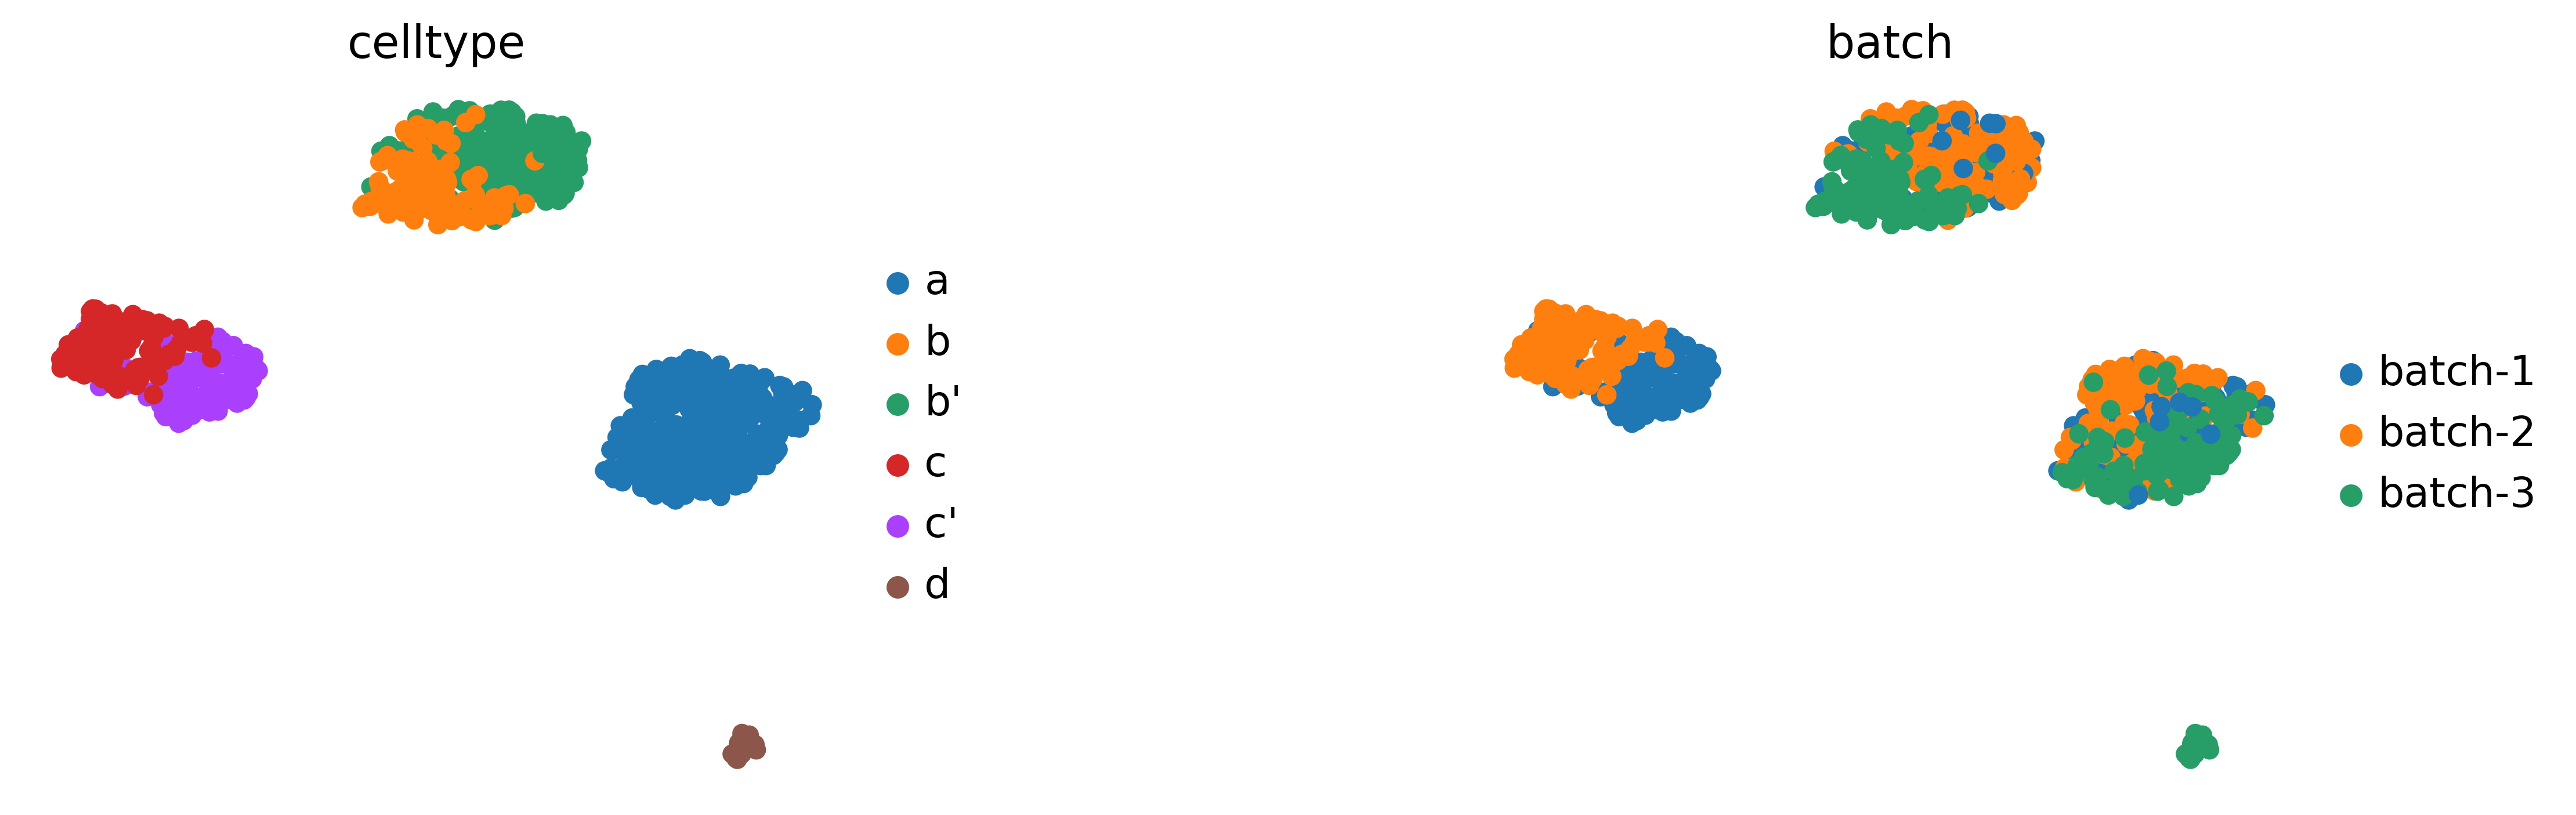

In [18]:
## 绘制整合后的UMAP图
ccVAE_eval.plot_latent(show=True,
                       save=False,
                       dir_path=None)

### Enhance the integration with cell-type information

In [19]:
from ccvae.step2_run_ccVAE import CCVAE
### Create TRVAE model and train it on reference dataset
ccvae = CCVAE(
    adata_ccPairs=source_adata,
    adata_rest=target_adata,
    #use_mmd = False,
    condition_key=condition_key,
    conditions=source_conditions,
    cell_type_key=cell_type_key,
    hidden_layer_sizes=[128, 128],
    recon_loss=['mse','mse'],
    mmd_on = 'z',
)


INITIALIZING THE WHOLE CCVAE NETWORK..............

Initializing ccVAE SubNetwork(trVAE) for ccPairs cells:
Encoder Sub-Architecture of ccPairs cells:
	Input Layer in, out and cond: 1000 128 3
	Hidden Layer 1 in/out: 128 128
	Mean/Var Layer in/out: 128 10

Decoder Sub-Architecture of ccPairs cells:
	First Layer in, out and cond:  10 128 3
	Hidden Layer 1 in/out: 128 128
	Output Layer in/out:  128 1000 


Initializing ccVAE SubNetwork(CVAE) for batch-free cells:
Encoder Sub-Architecture of rest cells:
	Input Layer in, out and cond: 1000 128 3
	Hidden Layer 1 in/out: 128 128
	Mean/Var Layer in/out: 128 10

Decoder Sub-Architecture of rest cells:
	First Layer in, out and cond:  10 128 3
	Hidden Layer 1 in/out: 128 128
	Output Layer in/out:  128 1000 



In [20]:
ccvae.train(
    n_epochs=ccvae_epochs,
    alpha_epoch_anneal=200,
    early_stopping_kwargs=early_stopping_kwargs,
    monitor_only_val = False,
    #train_frac = 0.8
)

Preparing (780, 1000) for ccPairs cells
Instantiating dataset of ccPairs cells
Preparing (40, 1000) for rest cells
Instantiating dataset of rest cells
 |████████████--------| 64.8%  - epoch_loss: 297.9195556641 - epoch_recon_loss: 143.5990295410 - epoch_kl_loss: 8.7952260971 - epoch_ccPairs_loss: 113.5174102783 - epoch_rest_loss: 30.0816020966 - epoch_center_loss: 0.2051378638 - epoch_ccPairs_center_loss: 0.1583800018 - epoch_rest_center_loss: 0.0467578396 - epoch_mmd_loss: 1.5160045624 - val_loss: 280.1276245117 - val_recon_loss: 130.2126770020 - val_kl_loss: 8.3553686142 - val_ccPairs_loss: 125.0611724854 - val_rest_loss: 5.1514983177 - val_center_loss: 0.2178364843 - val_ccPairs_center_loss: 0.2090571970 - val_rest_center_loss: 0.0087792715 - val_mmd_loss: 10.9112434387026699
ADJUSTED LR
 |█████████████-------| 66.2%  - epoch_loss: 298.0939941406 - epoch_recon_loss: 143.6394195557 - epoch_kl_loss: 8.9037361145 - epoch_ccPairs_loss: 113.9405364990 - epoch_rest_loss: 29.6988830566 - e

In [21]:
#import imp
from ccvae.step3_ccVAE_evaluation import CCVAE_EVAL
#imp.reload(CCVAE_EVAL)  # Reload the modified library

### Create anndata file of latent representation and compute UMAP
adata_latent = sc.AnnData(ccvae.get_latent())

ccVAE_eval = CCVAE_EVAL(adata_latent=adata_latent,
                       adata_ccPairs=source_adata,
                       adata_rest=target_adata,
                       condition_key=condition_key,
                       cell_type_key=cell_type_key,
                       n_neighbors=8)


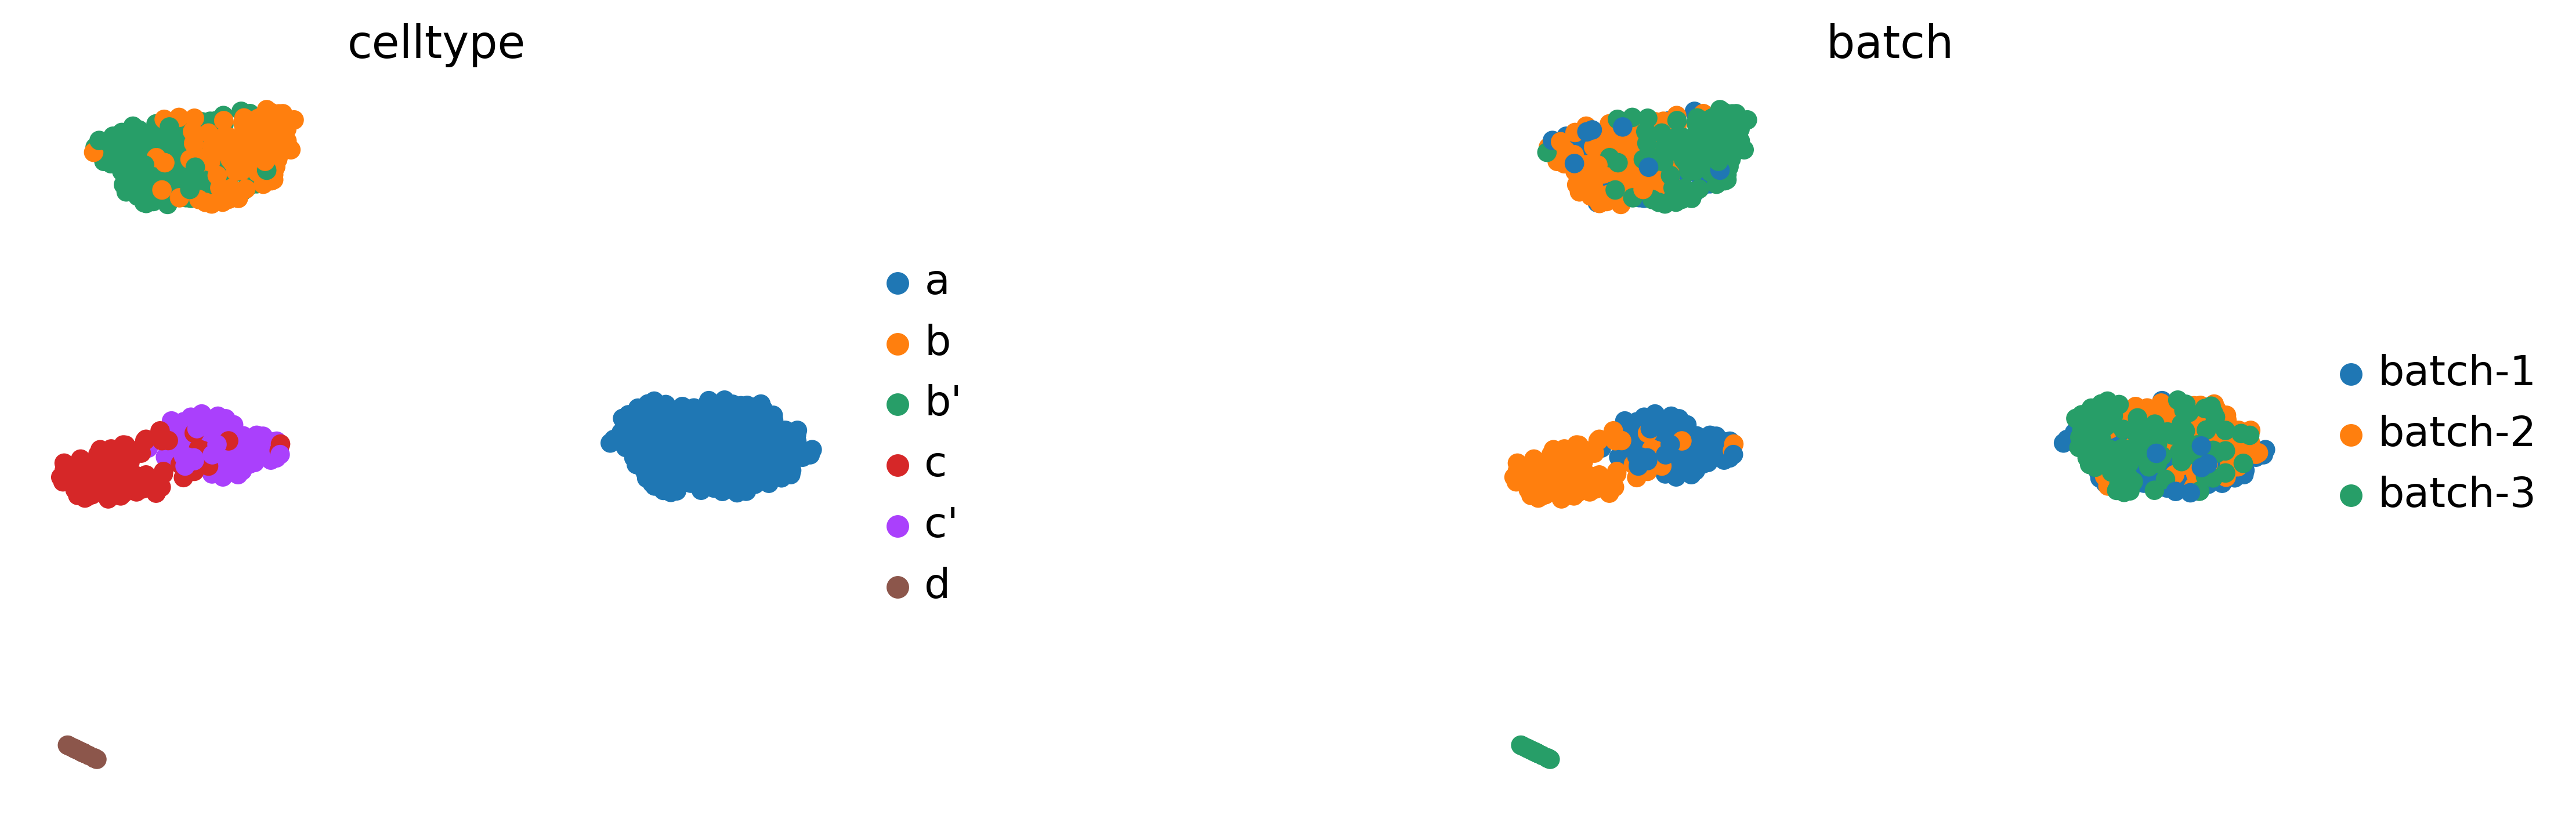

In [22]:
## 绘制整合后的UMAP图
ccVAE_eval.plot_latent(show=True,
                       save=False,
                       dir_path=None)